In [1]:
#Importing libraries
import networkx as nx
import simplejson as sjs
import json as js
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from networkx.readwrite import json_graph

In [2]:
# def read_json_graph(filename):
#     with open(filename) as f:
#         graph_data = js.load(f)
#     return json_graph.node_link_graph(graph_data)

# Read the JSON file
# with open('../EDA/star-wars-network-data-master/starwars-episode-1-interactions.json') as f:
#     json_data = js.loads(f.read())

with open('EDA/star-wars-network-data-master/starwars-episode-1-interactions_updated.json') as f:
    json_data_new = js.loads(f.read())

#j_graph = read_json_graph("../EDA/star-wars-network-data-master/starwars-episode-1-interactions.json")


In [3]:
# Instantiate the network Graph
G = nx.Graph()

# Derive the edges by crawling the nodes - Older version of JSON
# def crawl_old(jsdata):
#     tracker = {}
#     count = 0
#     for key, item in jsdata.items():
#         if isinstance(item, list):
#             for i in item:
#                 if "name" in i:
#                     tracker[i["name"]] = count
#                     count = count + 1
#                 elif "source" in i:
#                     val_list = list(tracker.values())
#                     key_list = list(tracker.keys())
#                     src_pos = val_list.index(i['source'])
#                     tgt_pos = val_list.index(i['target'])
#                     G.add_edge(key_list[src_pos], key_list[tgt_pos], weight = i['value'])

# Derive the edges by crawling the nodes - Newer version of JSON (Updated interactions JSON)
def crawl_new(jsdata):
    tracker = {}
    count = 0
    for key, item in jsdata.items():
        if isinstance(item, list):
            for i in item:
                if "id" in i:
                    tracker[i["id"]] = count
                    count = count + 1
                elif "source" in i:
                    G.add_edge(i['source'], i['target'], weight = i['value'])

# Crawl the JSON file
crawl_new(json_data_new)

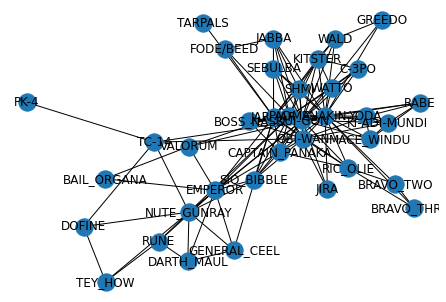

In [4]:
#Networkx plot using the draw function
nx.draw(G,with_labels=True)
#nx.edges(G)
#nx.nodes(G)

In [15]:
#Network Metrics for each episode
dgc = nx.degree_centrality(G) # degree of centrality
closeness = nx.closeness_centrality(G, u=None, distance=None) # closeness calculation
betweenness = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None) # betweenness calculation
evcentrality = nx.eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight='weight') # Eigen vector centrality calculation
nodes_list = nx.nodes(G)

#Converting to pandas dataframe
dgc_df = pd.DataFrame(list(dgc.items())).rename(columns={0: "character_name", 1: "degree_centrality"})
closeness_df = pd.DataFrame(list(closeness.items())).rename(columns={0: "character_name", 1: "closeness_centrality"})
betweenness_df = pd.DataFrame(list(betweenness.items())).rename(columns={0: "character_name", 1: "betweenness_centrality"})
evc_df = pd.DataFrame(list(evcentrality.items())).rename(columns={0: "character_name", 1: "eigenvector_centrality"})

#Build network metrics in a tabular format using pandas dataframe
dataframes = [dgc_df, closeness_df, betweenness_df, evc_df]
tabular_network_metrics = reduce(lambda left,right: pd.merge(left, right, on=['character_name'], how='inner'), dataframes)

tabular_network_metrics = tabular_network_metrics.set_index(['character_name'], drop=True)

# tabular_network_metrics['degree_centrality'] = tabular_network_metrics['degree_centrality'].apply(lambda x: round(x, 3))
# tabular_network_metrics['degree_centrality'] = tabular_network_metrics['degree_centrality'].round(2)

# tabular_network_metrics['closeness_centrality'] = tabular_network_metrics['closeness_centrality'].apply(lambda x: round(x, 3))
# tabular_network_metrics['betweenness_centrality'] = tabular_network_metrics['betweenness_centrality'].apply(lambda x: round(x, 3))
# tabular_network_metrics['eigenvector_centrality'] = tabular_network_metrics['eigenvector_centrality'].apply(lambda x: round(x, 3))

tabular_network_metrics.style.format('{0:,.3f}').highlight_max(color='lightblue')

,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
character_name,,,,
NUTE_GUNRAY,0.278,0.554,0.128,0.019
QUI-GON,0.694,0.766,0.319,0.568
PK-4,0.028,0.336,0.000,0.000
TC-14,0.139,0.500,0.075,0.015
OBI-WAN,0.361,0.571,0.047,0.367
DOFINE,0.083,0.375,0.002,0.001
RUNE,0.111,0.391,0.004,0.004
TEY_HOW,0.083,0.367,0.001,0.000
CAPTAIN_PANAKA,0.250,0.545,0.010,0.214


In [16]:
tabular_network_metrics.style.format('{0:,.3f}').background_gradient()

,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
character_name,,,,
NUTE_GUNRAY,0.278,0.554,0.128,0.019
QUI-GON,0.694,0.766,0.319,0.568
PK-4,0.028,0.336,0.000,0.000
TC-14,0.139,0.500,0.075,0.015
OBI-WAN,0.361,0.571,0.047,0.367
DOFINE,0.083,0.375,0.002,0.001
RUNE,0.111,0.391,0.004,0.004
TEY_HOW,0.083,0.367,0.001,0.000
CAPTAIN_PANAKA,0.250,0.545,0.010,0.214


In [37]:
json_data_with_metrics = json_data_new.copy()
for node in json_data_with_metrics['nodes']:
	node['degree_centrality'] = tabular_network_metrics.loc[node['id']]['degree_centrality']
	node['closeness_centrality'] = tabular_network_metrics.loc[node['id']]['closeness_centrality']
	node['betweenness_centrality'] = tabular_network_metrics.loc[node['id']]['betweenness_centrality']
	node['eigenvector_centrality'] = tabular_network_metrics.loc[node['id']]['eigenvector_centrality']

with open('EDA/star-wars-network-data-master/starwars-episode-1-interactions_updated_with_metrics.json', 'w', encoding='utf-8') as f:
    f.write(js.dumps(json_data_with_metrics, ensure_ascii=False))

tabular_network_metrics.to_csv('files/tabular_network_metrics_episode1.csv')